In [2]:

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from ast import arg
import matplotlib.pyplot as plt
from tqdm import tqdm

import scipy

def fit(xs, y, optim_f, init_grid, top_k=500, n_proc=8, tol=None, disp=False, maxiter=None):
        _, _, brute_xs, brute_ys = scipy.optimize.brute(optim_f, init_grid, args=(xs, y), full_output=True, finish=None, Ns=1, workers=-1)

        brute_xs = brute_xs.reshape(brute_xs.shape[0], -1)
        brute_ys = brute_ys.reshape(-1)

        top_idxs = np.argsort(brute_ys)[:top_k]
        top_xs = brute_xs[:, top_idxs]
        # top_ys = brute_ys[top_idxs]
        preds = []
        for i in tqdm(range(top_xs.shape[1])):
            options = {'disp': disp}
            if maxiter: options['maxiter'] = maxiter
            pred = scipy.optimize.minimize(optim_f, top_xs[:, i], args=(xs, y), method='L-BFGS-B', tol=tol, options=options).x
            loss = optim_f(pred, xs, y)
            # print(pred, loss)
            preds.append((pred, loss))
        return sorted(preds, key=lambda x: x[1])[0][0]

def power_law_with_const_min(args, *params):
    x,y = params
    a,b,c = args
    # return ((power_law_with_const(x,a,b,c) - y) ** 2).mean()
    return ((np.log(power_law_with_const(x,a,b,c) / y)) ** 2).mean()

def power_law_with_const(x, a, b, c): return c + (x/b)**(-a)


In [7]:
import pandas as pd
import zipfile
import numpy as np

# Load data from zip file
zip_path = "data/dmc_122124.zip"
zip_path = "data/dmc_122724.zip"
records = []

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    for filename in zip_ref.namelist():
        if filename.endswith('.npy'):
            # Extract parameters from directory name (e.g. BRO_64_1_3e-4)
            env_name = filename.split('/')[2].split('.')[0]  # Get environment name from path
            name = filename.split('/')[1]
            params = name.split('_')
            batch_size = int(params[1])
            utd = int(params[2])
            learning_rate = float(params[3])
            
            # Load array data
            with zip_ref.open(filename) as f:
                arr = np.load(f)
                
            # Create record with metadata and results
            records.append({
                'env_name': env_name,
                'batch_size': batch_size,
                'utd': utd,
                'learning_rate': learning_rate,
                'training_step': arr[:, 0],
                'return': arr[:, 1:],
                'mean_return': np.mean(arr[:, 1:], axis=1),  # Add summary statistics
                'std_return': np.std(arr[:, 1:], axis=1) / np.sqrt(10)  # Standard Error of Mean over 10 seeds
            })

# Convert to pandas DataFrame
df = pd.DataFrame(records)

        
df

,env_name,batch_size,utd,learning_rate,training_step,return,mean_return,std_return
0,dog-stand,64,8,0.00015,"[5000.0, 6000.0, 7000.0, 8000.0, 9000.0, 10000...","[[0.012786157760283771, 0.008792589896180762, ...","[0.009076612890084036, 20.560380677249054, 20....","[0.0023219206751776598, 1.3897536796960757, 1...."
1,reacher-easy,64,8,0.00015,"[5000, 6000, 7000, 8000, 9000, 10000, 11000, 1...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [119, 0, 303,...","[0.0, 111.2, 212.1, 255.3, 577.6, 126.6, 197.1...","[0.0, 65.69745809390191, 101.81114379084443, 1..."
2,hopper-stand,64,8,0.00015,"[5000.0, 6000.0, 7000.0, 8000.0, 9000.0, 10000...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 1.0712729879328584, 2.4090577922881935, ...","[0.0, 1.0162987913045725, 1.6042998125899615, ..."
3,finger-spin,64,8,0.00015,"[5000, 6000, 7000, 8000, 9000, 10000, 11000, 1...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 0, 0, 0, ...","[0.0, 1.0, 0.7, 1.1, 13.7, 16.8, 37.7, 84.4, 1...","[0.0, 0.565685424949238, 0.2846049894151541, 0..."
4,quadruped-walk,64,8,0.00015,"[5000.0, 6000.0, 7000.0, 8000.0, 9000.0, 10000...","[[0.9019667793428906, 0.0012992603305187961, 0...","[0.297271077197421, 257.3430544775937, 113.387...","[0.12631542565691756, 79.7073005048898, 64.046..."
...,...,...,...,...,...,...,...,...
115,dog-stand,256,1,0.00030,"[5000.0, 6000.0, 7000.0, 8000.0, 9000.0, 10000...","[[0.0025101940236721015, 0.01228352635781535, ...","[0.008199603641316583, 21.80759596732161, 19.1...","[0.0027724402979911996, 1.29945546909247, 0.94..."
116,reacher-easy,256,1,0.00030,"[5000, 6000, 7000, 8000, 9000, 10000, 11000, 1...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [57, 218, 67,...","[0.0, 50.7, 116.8, 164.4, 71.4, 32.2, 169.0, 2...","[0.0, 21.015732202328802, 53.89022174754897, 8..."
117,hopper-stand,256,1,0.00030,"[5000.0, 6000.0, 7000.0, 8000.0, 9000.0, 10000...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 0.8106233921928364, 1.6686003410130124, ...","[0.0, 0.7690248731823952, 1.0641777507083656, ..."
118,finger-spin,256,1,0.00030,"[5000, 6000, 7000, 8000, 9000, 10000, 11000, 1...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 4, 0, 0, ...","[0.0, 0.9, 0.1, 0.9, 0.3, 0.9, 1.6, 0.1, 0.1, ...","[0.0, 0.498998997994986, 0.09486832980505139, ..."


In [8]:

# for walker-walk only truncate after 200000 training steps
# Create a mask for walker-walk data points after 200000 steps
for i, row in df.iterrows():
    if row['env_name'] == 'walker-walk':
        mask = row['training_step'] > 150000
        df.at[i, 'return'] = row['return'][~mask]
        df.at[i, 'training_step'] = row['training_step'][~mask]
        df.at[i, 'mean_return'] = np.mean(row['return'], axis=1)
        df.at[i, 'std_return'] = np.std(row['return'], axis=1)

for i, row in df.iterrows():
    if row['env_name'] == 'quadruped-walk':
        mask = row['training_step'] > 600000
        df.at[i, 'return'] = row['return'][~mask]
        df.at[i, 'training_step'] = row['training_step'][~mask]
        df.at[i, 'mean_return'] = np.mean(row['return'], axis=1)
        df.at[i, 'std_return'] = np.std(row['return'], axis=1)

IndexError: index 4 is out of bounds for axis 1 with size 4

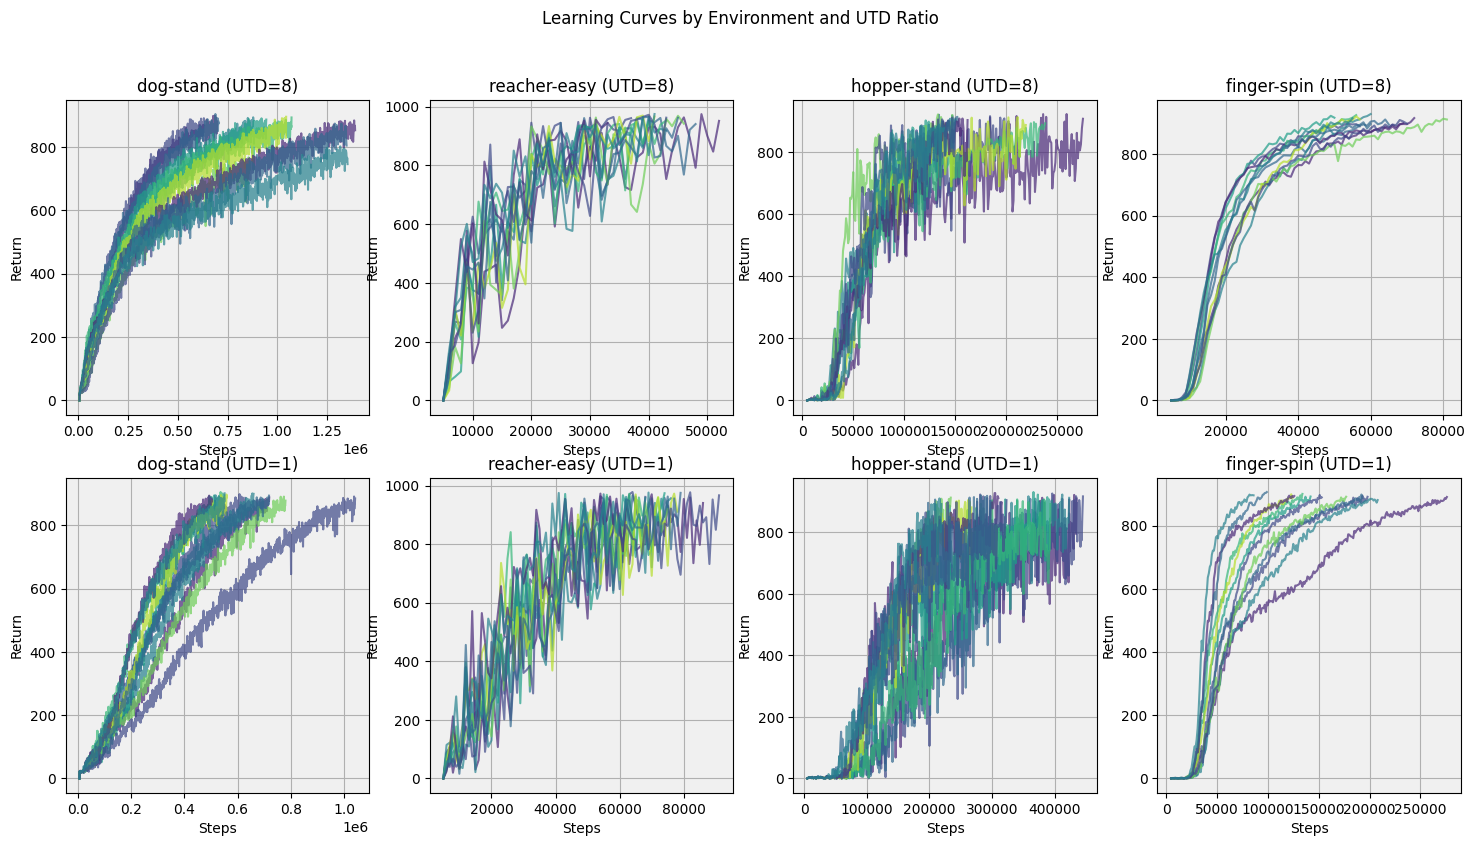

In [9]:
# plot curves

import matplotlib.pyplot as plt
import seaborn as sns

colors = sns.color_palette("viridis", n_colors=8)  # Using viridis for a nice gradient
fig, axs = plt.subplots(2, 4, figsize=(18, 9))
fig.suptitle('Learning Curves by Environment and UTD Ratio')

lines = []
labels = []
config_colors = {}
color_idx = 0

df_filtered = df[df['batch_size'] == 64]
df_filtered = df
# df_filtered = df_filtered[df_filtered['learning_rate'] == 3e-4]

# Group data by environment and UTD ratio
for i, env in enumerate(df['env_name'].unique()):
    env_data = df_filtered[df_filtered['env_name'] == env]
    
    # Create separate plots for each UTD value
    for j, utd in enumerate(env_data['utd'].unique()):
        utd_data = env_data[env_data['utd'] == utd]
        # Sort by batch size and learning rate
        utd_data = utd_data.sort_values(['utd', 'batch_size', 'learning_rate'])
        
        ax = axs[j, i]
        ax.set_title(f'{env} (UTD={utd})')
        
        for _, row in utd_data.iterrows():
            config = (row['batch_size'], row['learning_rate'])
            if config not in config_colors:
                config_colors[config] = color_idx
                color_idx += 1
            
            label = f"bs={row['batch_size']}, lr={row['learning_rate']}"
            results = row['mean_return']
            line = ax.plot(row['training_step'], results, alpha=0.7, color=colors[config_colors[config] % len(colors)])
            
            # Only add to legend if we haven't seen this combination before
            if label not in labels:
                lines.append(line[0])
                labels.append(label)
        
        ax.set_xlabel('Steps')
        ax.set_ylabel('Return')
        ax.grid(True)
        
        # Set background color
        ax.set_facecolor('#f0f0f0')

# Sort labels by batch size and learning rate
sorted_indices = [i for i, _ in sorted(enumerate(labels), 
                                     key=lambda x: tuple(map(float, x[1].replace("bs=","").replace("lr=","").split(", "))))]
lines = [lines[i] for i in sorted_indices]
labels = [labels[i] for i in sorted_indices]

# Create a single legend outside all subplots
fig.legend(lines, labels, bbox_to_anchor=(0.5, 0), loc='upper center', ncol=(len(labels) // 2)+1, fontsize=12)
plt.tight_layout()
plt.show()

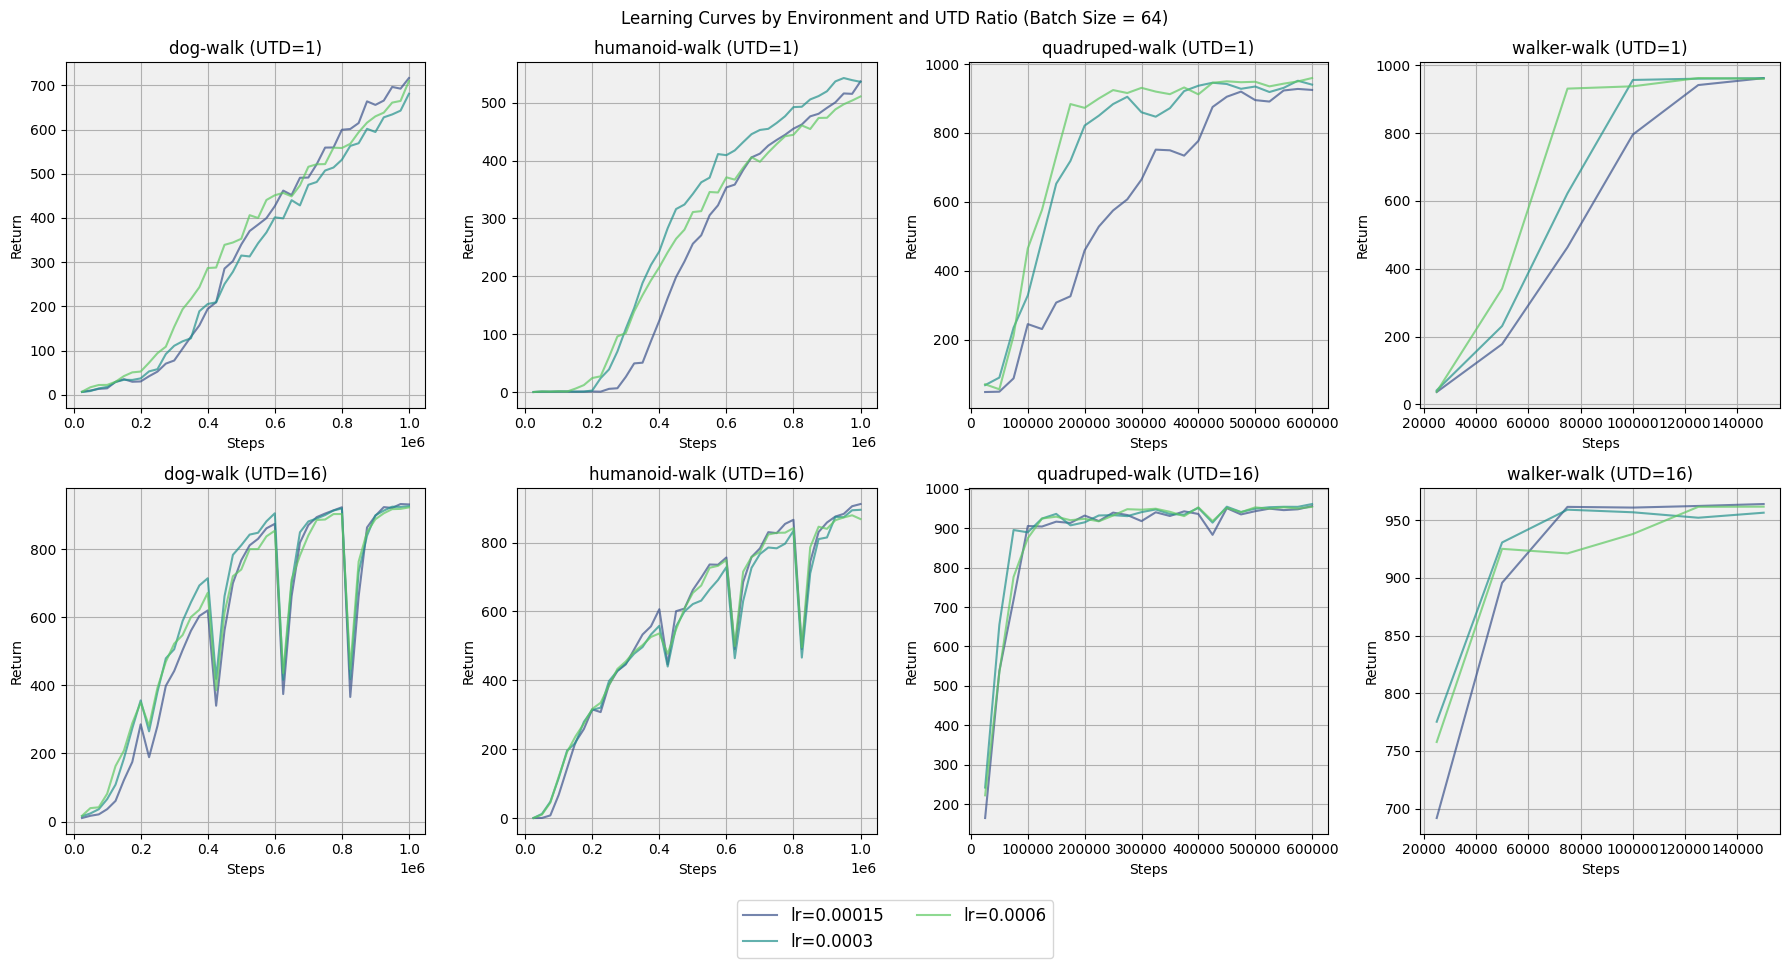

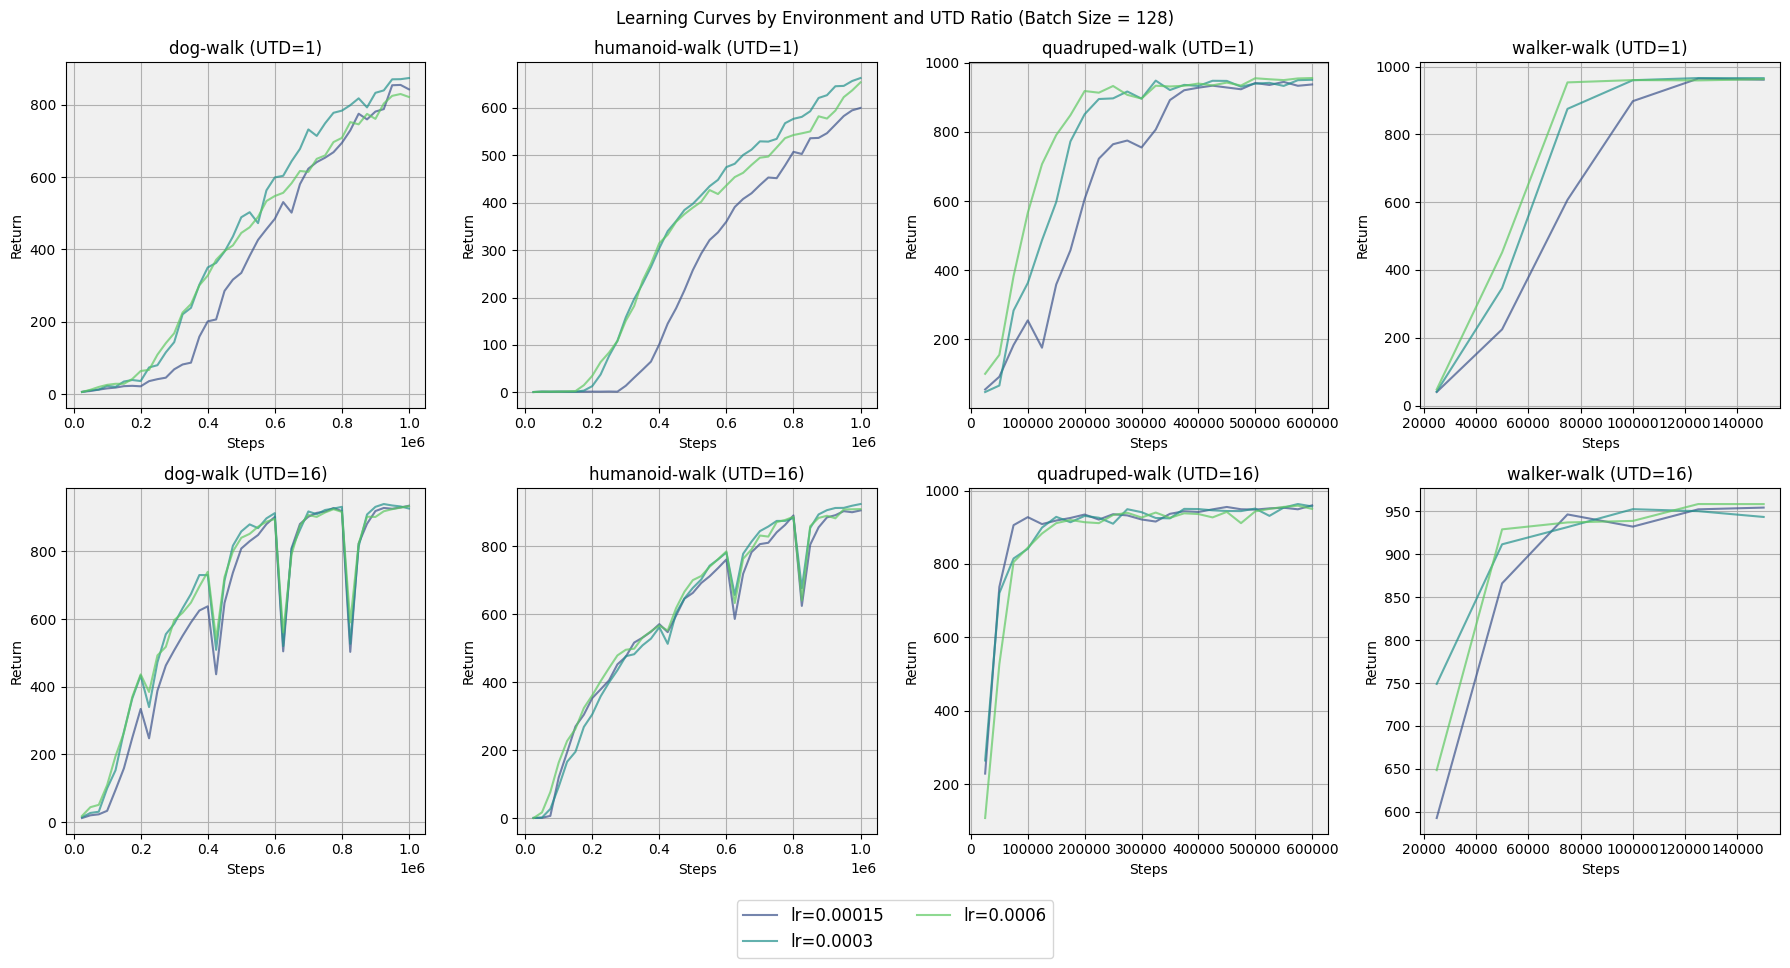

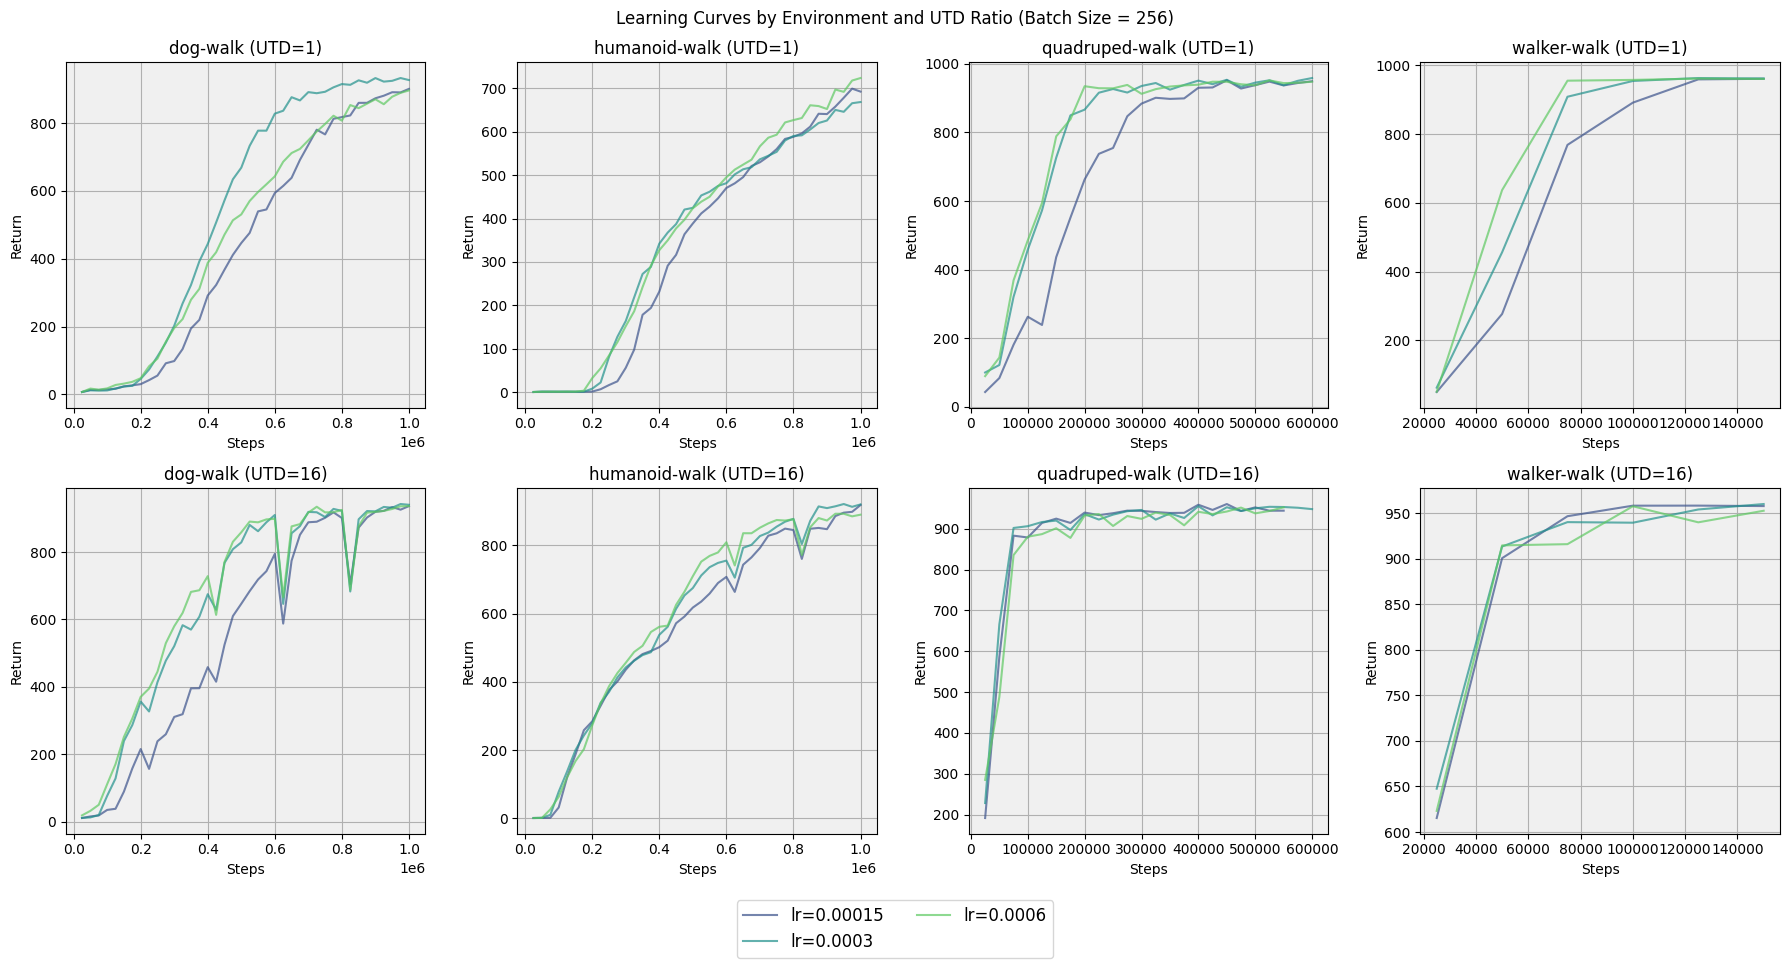

In [144]:
# plot curves

import matplotlib.pyplot as plt
import seaborn as sns

# Get unique batch sizes
batch_sizes = sorted(df['batch_size'].unique())

# Create a separate plot for each batch size
for batch_size in batch_sizes:
    colors = sns.color_palette("viridis", n_colors=3)  # Using viridis for a nice gradient
    fig, axs = plt.subplots(2, 4, figsize=(18, 9))
    fig.suptitle(f'Learning Curves by Environment and UTD Ratio (Batch Size = {batch_size})')

    lines = []
    labels = []
    config_colors = {}
    color_idx = 0

    # Filter data for current batch size
    df_filtered = df[df['batch_size'] == batch_size]

    # Group data by environment and UTD ratio
    for i, env in enumerate(sorted(df['env_name'].unique())):
        env_data = df_filtered[df_filtered['env_name'] == env]
        
        # Create separate plots for each UTD value
        for j, utd in enumerate(sorted(env_data['utd'].unique())):
            utd_data = env_data[env_data['utd'] == utd]
            # Sort by learning rate only since we're already filtering by UTD
            utd_data = utd_data.sort_values('learning_rate')
            
            ax = axs[j, i]
            ax.set_title(f'{env} (UTD={utd})')
            
            for _, row in utd_data.iterrows():
                config = row['learning_rate']
                if config not in config_colors:
                    config_colors[config] = color_idx
                    color_idx += 1
                
                label = f"lr={row['learning_rate']}"
                results = row['mean_return']
                line = ax.plot(row['training_step'], results, alpha=0.7, color=colors[config_colors[config] % len(colors)])
                
                # Only add to legend if we haven't seen this combination before
                if label not in labels:
                    lines.append(line[0])
                    labels.append(label)
            
            ax.set_xlabel('Steps')
            ax.set_ylabel('Return')
            ax.grid(True)
            
            # Set background color
            ax.set_facecolor('#f0f0f0')

    # Sort labels by learning rate
    sorted_indices = [i for i, _ in sorted(enumerate(labels), 
                                         key=lambda x: float(x[1].replace("lr=","")))]
    lines = [lines[i] for i in sorted_indices]
    labels = [labels[i] for i in sorted_indices]

    # Create a single legend outside all subplots
    fig.legend(lines, labels, bbox_to_anchor=(0.5, 0), loc='upper center', ncol=(len(labels) // 2)+1, fontsize=12)
    plt.tight_layout()
    plt.show()

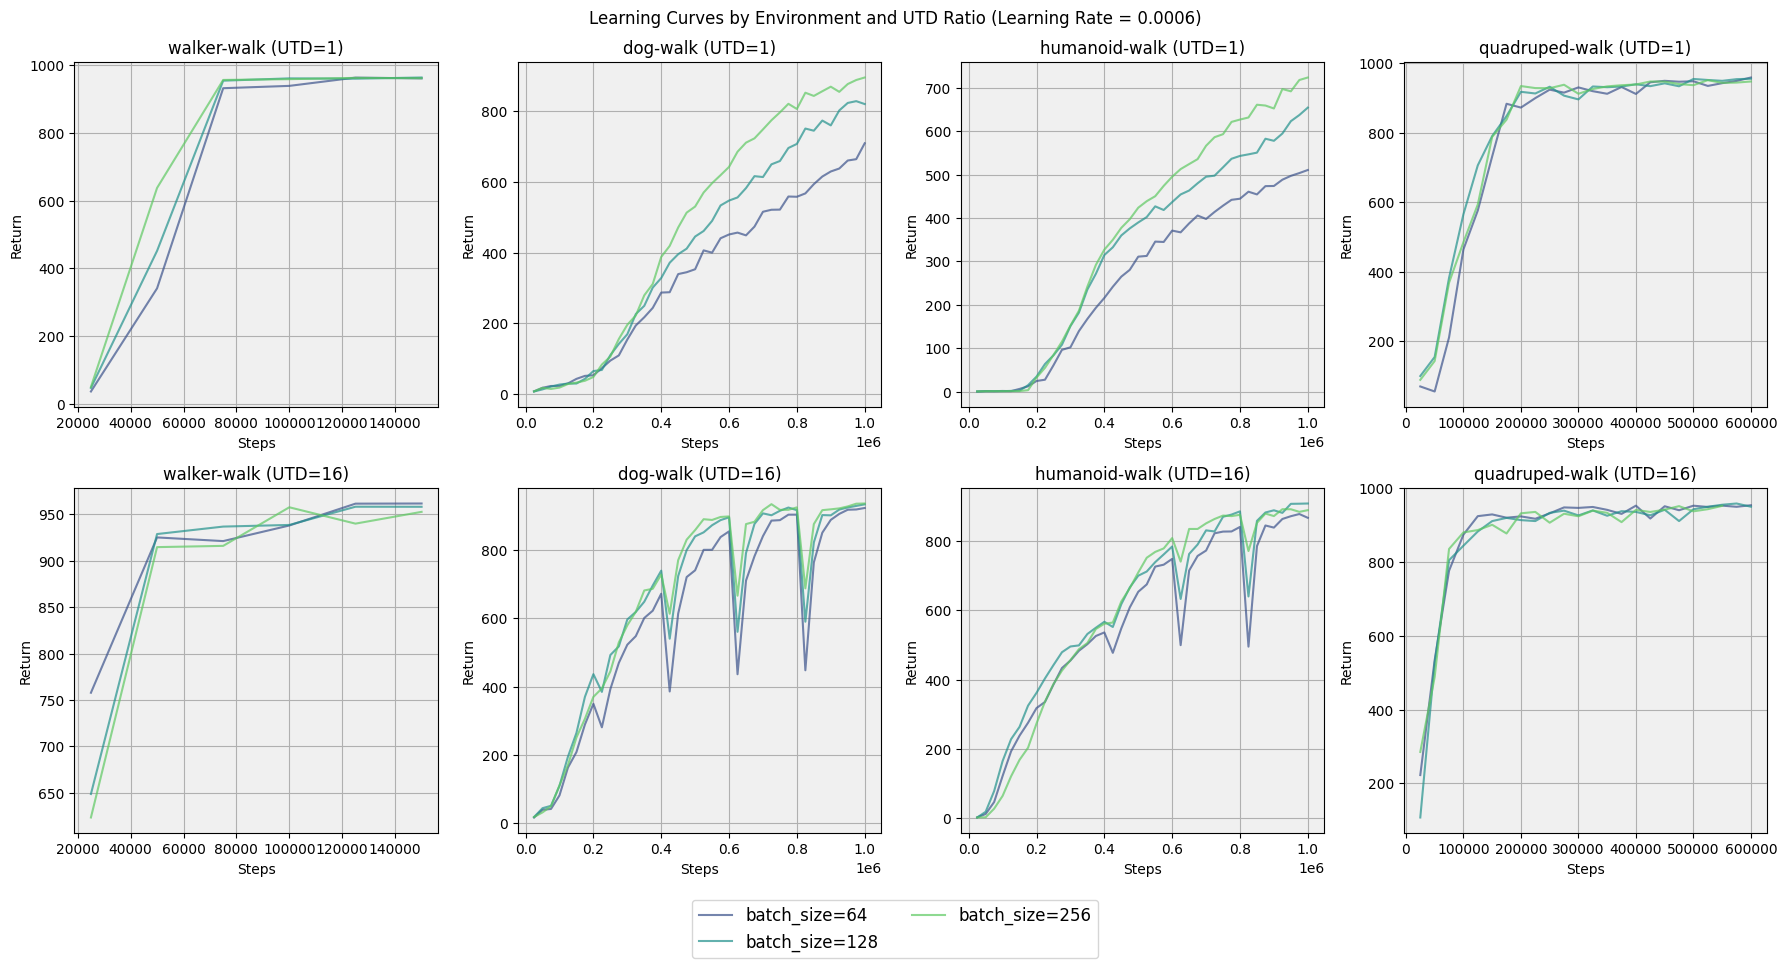

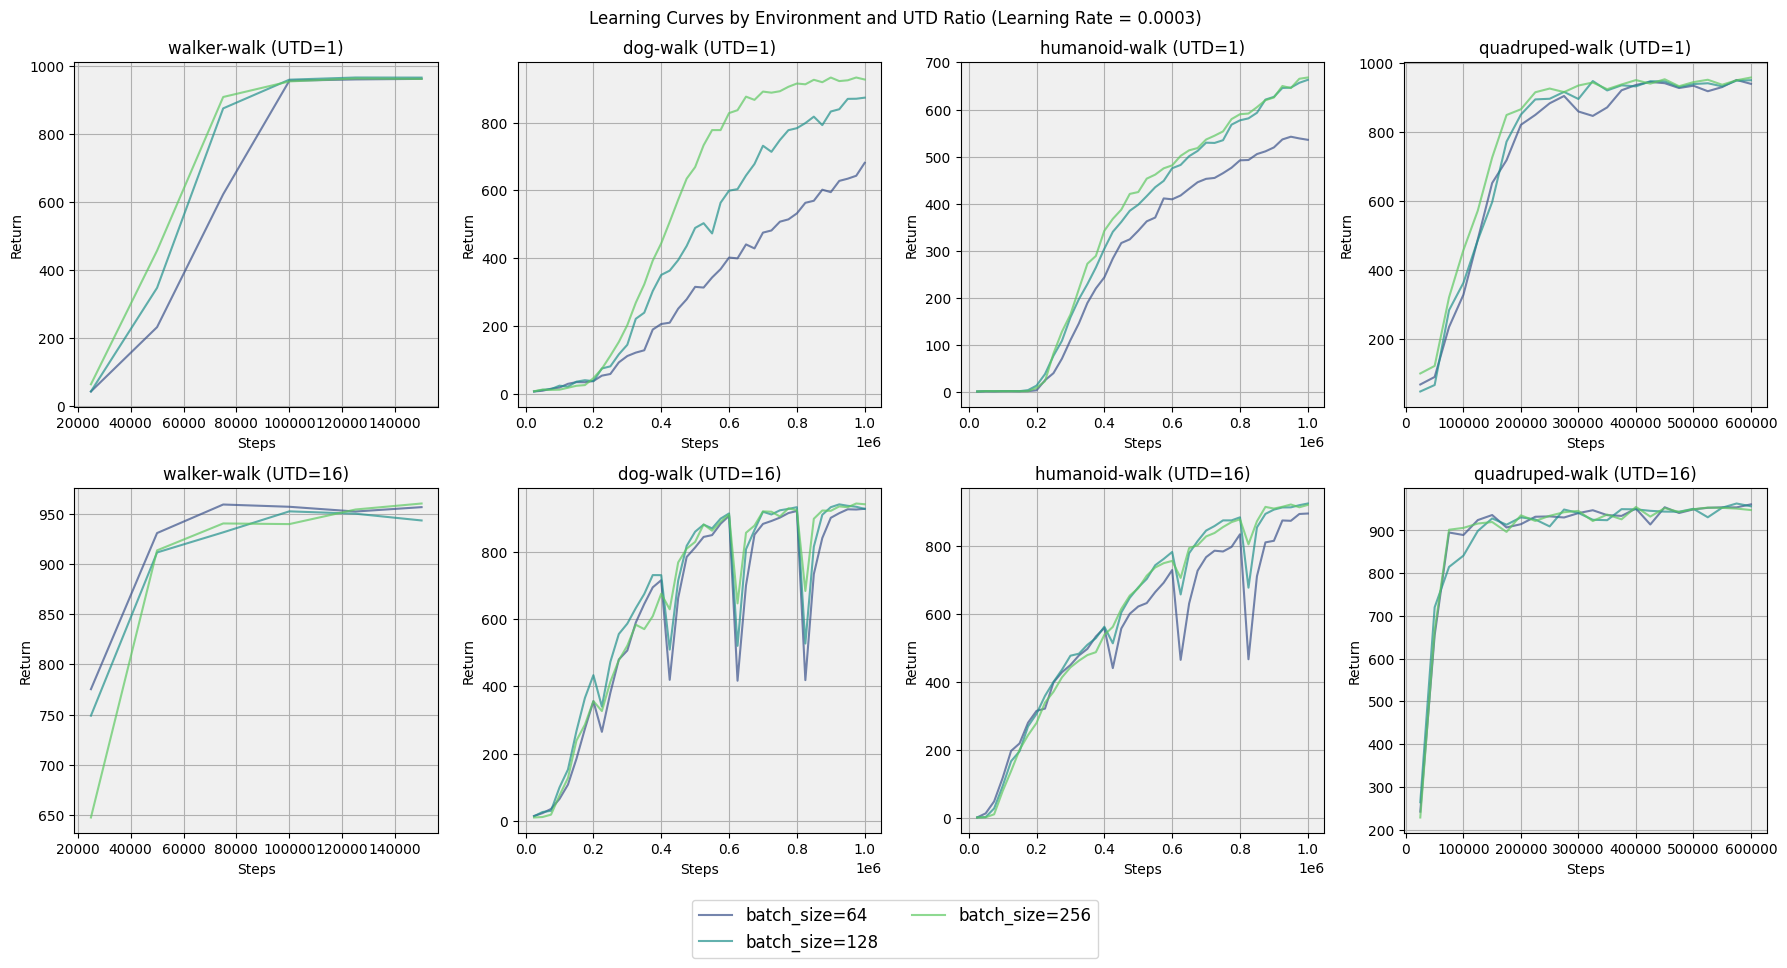

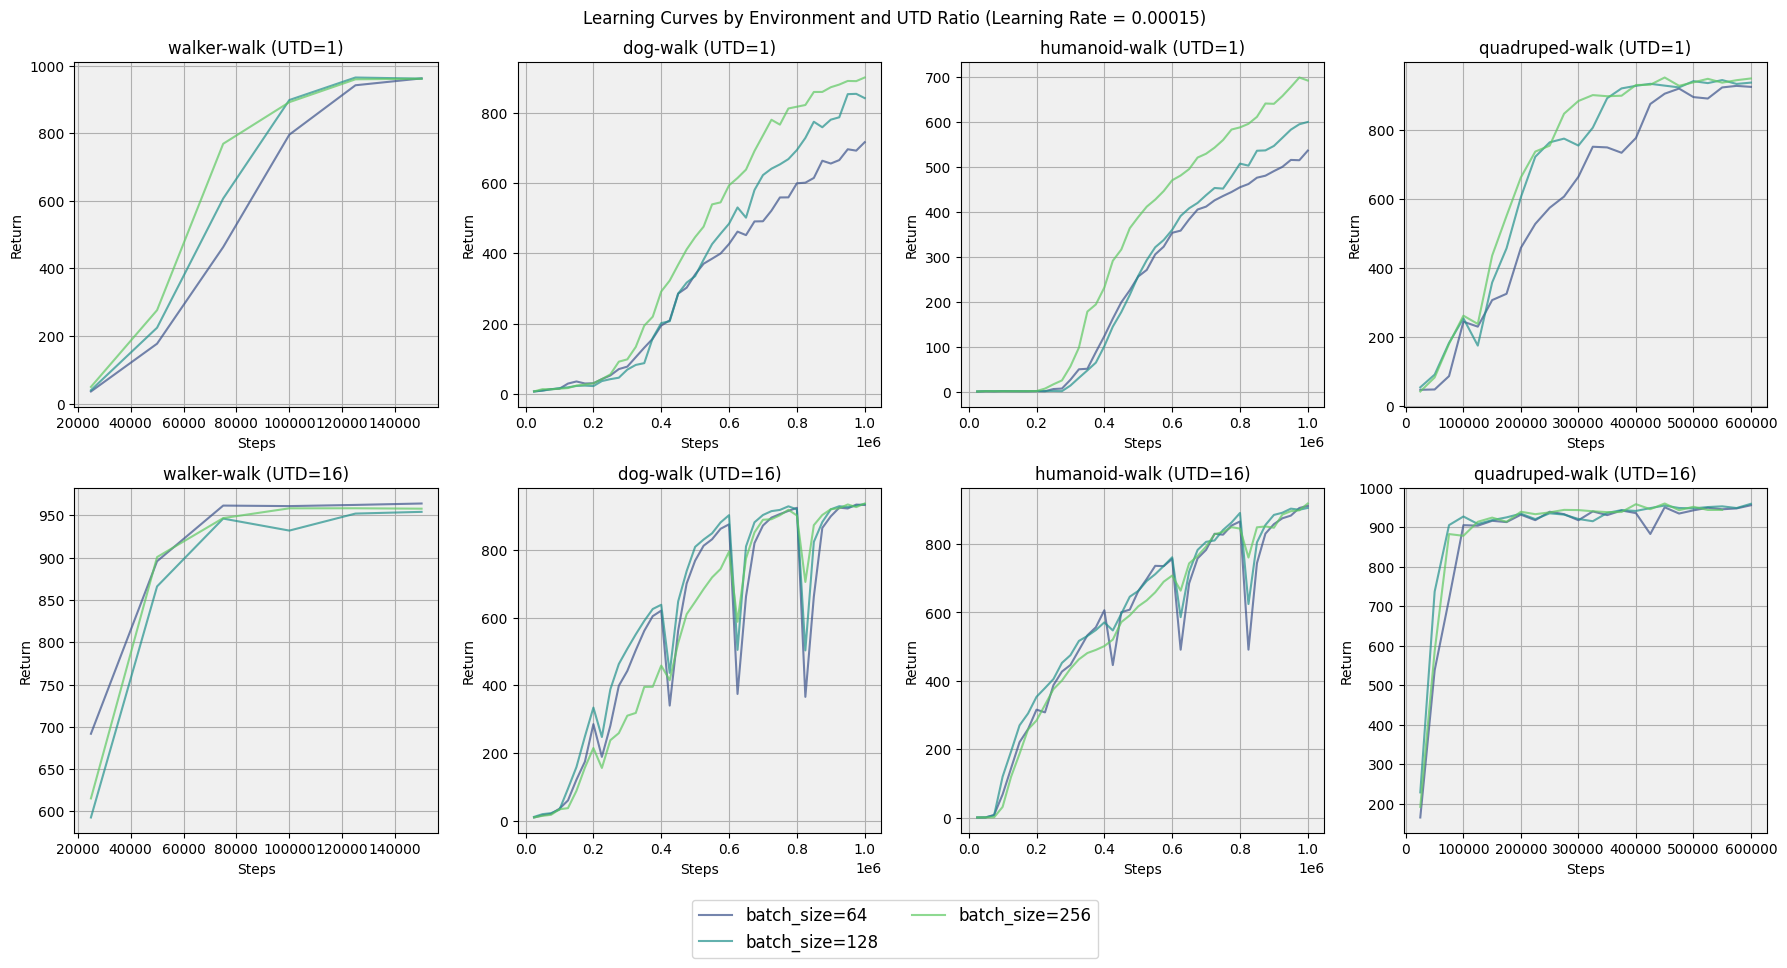

In [145]:
# plot curves

import matplotlib.pyplot as plt
import seaborn as sns

# Get unique learning rates
learning_rates = df['learning_rate'].unique()

# Create a separate plot for each learning rate
for lr in learning_rates:
    colors = sns.color_palette("viridis", n_colors=3)  # Using viridis for a nice gradient
    fig, axs = plt.subplots(2, 4, figsize=(18, 9))
    fig.suptitle(f'Learning Curves by Environment and UTD Ratio (Learning Rate = {lr})')

    lines = []
    labels = []
    config_colors = {}
    color_idx = 0

    # Filter data for current learning rate
    df_filtered = df[df['learning_rate'] == lr]

    # Group data by environment and UTD ratio
    for i, env in enumerate(df['env_name'].unique()):
        env_data = df_filtered[df_filtered['env_name'] == env]
        
        # Create separate plots for each UTD value
        for j, utd in enumerate(sorted(env_data['utd'].unique())):
            utd_data = env_data[env_data['utd'] == utd]
            # Sort by UTD
            utd_data = utd_data.sort_values('batch_size')
            
            ax = axs[j, i]
            ax.set_title(f'{env} (UTD={utd})')
            
            for _, row in utd_data.iterrows():
                config = row['batch_size']
                if config not in config_colors:
                    config_colors[config] = color_idx
                    color_idx += 1
                
                label = f"batch_size={row['batch_size']}"
                results = row['mean_return']
                line = ax.plot(row['training_step'], results, alpha=0.7, color=colors[config_colors[config] % len(colors)])
                
                # Only add to legend if we haven't seen this combination before
                if label not in labels:
                    lines.append(line[0])
                    labels.append(label)
            
            ax.set_xlabel('Steps')
            ax.set_ylabel('Return')
            ax.grid(True)
            
            # Set background color
            ax.set_facecolor('#f0f0f0')

    # Sort labels by batch size
    sorted_indices = [i for i, _ in sorted(enumerate(labels), 
                                         key=lambda x: float(x[1].replace("batch_size=","")))]
    lines = [lines[i] for i in sorted_indices]
    labels = [labels[i] for i in sorted_indices]

    # Create a single legend outside all subplots
    fig.legend(lines, labels, bbox_to_anchor=(0.5, 0), loc='upper center', ncol=(len(labels) // 2)+1, fontsize=12)
    plt.tight_layout()
    plt.show()

In [1]:
# Plot learning rate vs performance for each environment, batch size and UTD
unique_envs = sorted(df['env_name'].unique())
unique_batch_sizes = sorted(df['batch_size'].unique()) 
unique_utds = sorted(df['utd'].unique())

fig, axs = plt.subplots(4, 6, figsize=(15, 10))

plot_idx = 0
for row, env in enumerate(unique_envs):   
    for utd in unique_utds:
        for batch_size in unique_batch_sizes:
            col = plot_idx % 6
            env_data = df[df['env_name'] == env]
            data = env_data[(env_data['batch_size'] == batch_size) & 
                           (env_data['utd'] == utd)]
            
            if len(data) == 0:
                continue
                
            # Get final performance stats
            final_returns = data.apply(lambda x: x['mean_return'][-1], axis=1)
            final_stds = data.apply(lambda x: x['std_return'][-1], axis=1)
            
            # Group by learning rate
            lr_groups = data.groupby('learning_rate')
            mean_returns = lr_groups.apply(lambda x: np.mean([r[-1] for r in x['mean_return']]))
            std_returns = lr_groups.apply(lambda x: np.mean([s[-1] for s in x['std_return']]))
            
            lrs = sorted(lr_groups.groups.keys())
            means = [mean_returns[lr] for lr in lrs]
            stds = [std_returns[lr] for lr in lrs]
            
            axs[row, col].errorbar(lrs, means, yerr=stds, fmt='o-', capsize=5, label=env)
            
            axs[row, col].set_xscale('log')
            axs[row, col].set_xlabel('Learning Rate')
            axs[row, col].set_ylabel('Final Return')
            axs[row, col].set_title(f'batch_size={batch_size}, utd={utd}')
            axs[row, col].legend(fontsize='small')
            axs[row, col].grid(True)
            
            plot_idx += 1

plt.tight_layout()
plt.show()


NameError: name 'df' is not defined

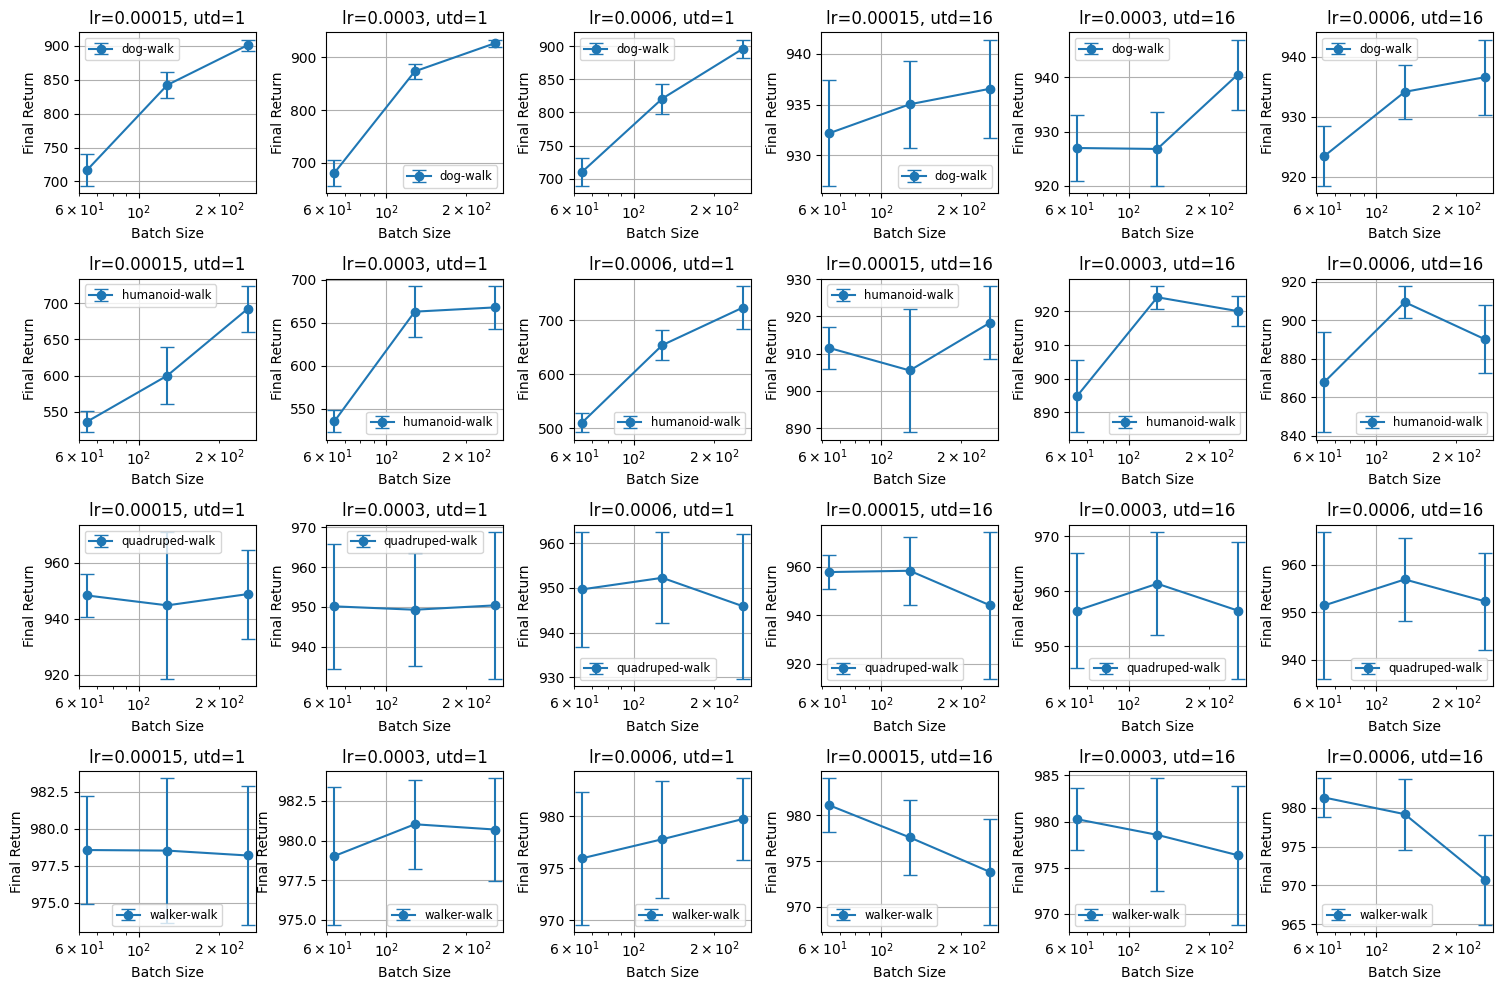

In [8]:
# Plot batch size vs performance for each environment, learning rate and UTD
unique_envs = sorted(df['env_name'].unique())
unique_lrs = sorted(df['learning_rate'].unique())
unique_utds = sorted(df['utd'].unique())

fig, axs = plt.subplots(4, 6, figsize=(15, 10))

plot_idx = 0
for row, env in enumerate(unique_envs):   
    for utd in unique_utds:
        for lr in unique_lrs:
            col = plot_idx % 6
            env_data = df[df['env_name'] == env]
            data = env_data[(env_data['learning_rate'] == lr) & 
                           (env_data['utd'] == utd)]
            
            if len(data) == 0:
                continue
                
            # Get final performance stats
            final_returns = data.apply(lambda x: x['mean_return'][-1], axis=1)
            final_stds = data.apply(lambda x: x['std_return'][-1], axis=1)
            
            # Group by batch size
            batch_groups = data.groupby('batch_size')
            mean_returns = batch_groups.apply(lambda x: np.mean([r[-1] for r in x['mean_return']]))
            std_returns = batch_groups.apply(lambda x: np.mean([s[-1] for s in x['std_return']]))
            
            batch_sizes = sorted(batch_groups.groups.keys())
            means = [mean_returns[bs] for bs in batch_sizes]
            stds = [std_returns[bs] for bs in batch_sizes]
            
            axs[row, col].errorbar(batch_sizes, means, yerr=stds, fmt='o-', capsize=5, label=env)
            
            axs[row, col].set_xscale('log')
            axs[row, col].set_xlabel('Batch Size')
            axs[row, col].set_ylabel('Final Return')
            axs[row, col].set_title(f'lr={lr}, utd={utd}')
            axs[row, col].legend(fontsize='small')
            axs[row, col].grid(True)
            
            plot_idx += 1

plt.tight_layout()
plt.show()


In [19]:
batch_utd_data

,env_name,batch_size,utd,learning_rate,training_step,return,mean_return,std_return
15,quadruped-walk,128,16,0.00030,"[25000.0, 50000.0, 75000.0, 100000.0, 125000.0...","[[359.1527724173735, 351.64516262816124, 199.0...","[264.2290758312373, 720.4573254684307, 814.790...","[125.23133739180562, 224.47736553702, 149.0461..."
31,quadruped-walk,128,16,0.00060,"[25000.0, 50000.0, 75000.0, 100000.0, 125000.0...","[[101.49729630180583, 60.34074208729051, 161.9...","[107.54421021581534, 527.099604719695, 804.975...","[82.60956149056514, 259.2588293088192, 186.577..."
63,quadruped-walk,128,16,0.00015,"[25000.0, 50000.0, 75000.0, 100000.0, 125000.0...","[[126.47567002745443, 409.1419097666383, 212.5...","[228.60548320996182, 737.2552817301346, 905.59...","[130.27716479583614, 158.09259890800203, 66.39..."


  0%|          | 0/125 [00:00<?, ?it/s]/home/oleh/miniconda3/envs/rlgpu/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in power
  # Remove the CWD from sys.path while we load stuff.
100%|██████████| 125/125 [00:01<00:00, 90.01it/s]


loss 0.007633970780512636
y = 8.77e+00 / (1 + x/2.57e-03)^-2.62e-01


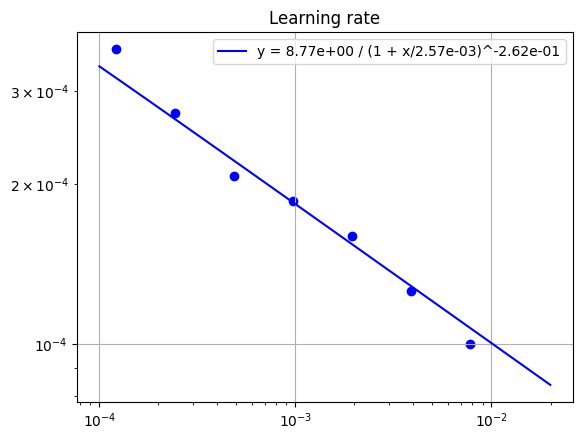

In [146]:
# large-batch training - fit() - uncertainty-corrected

def lr_rule_min(args, *params):
    x,y = params
    a,b,c = args
    return ((lr_rule(x,a,b,c) - y) ** 2).mean()
    # return ((np.log(lr_rule(x,a,b,c) / y)) ** 2).mean()

def lr_rule(x, a, b, c):
    return c * (1 + x/b) ** (-a)

n_parallel = np.array([128, 1024, 2048, 4096, 8192, 16384, 32768, 65536])
utd = 1/n_parallel * 8
learning_rate = np.array([4e-5, 1e-4, 1.26e-4, 1.6e-4, 2e-4, 2e-4, 2.5e-4, 3.7e-4])
learning_rate = np.array([4e-5, 1e-4, 1.26e-4, 1.6e-4, 1.86e-4, 2.07e-4, 2.73e-4, 3.6e-4]) # uncertainty corrected
fit_data_points = [3, 4, 5, 6]
plot_data_points = [1, 2, 3, 4, 5, 6, 7]
tried_values = [[4e-5], [1e-4, 2e-4], [1.26e-4, 1e-4, 2e-4], [1.6e-4, 1e-4, 2e-4], [2e-4, 1e-4], [2e-4, 2.5e-4, 3.2e-4], [2.5e-4, 2e-4], [3.2e-4, 2.7e-4, 3.7e-4]]

scaling = [1000, 10000]
fitted_params = fit(utd[fit_data_points] * scaling[0], learning_rate[fit_data_points] * scaling[1], lr_rule_min,
                     [slice(-4, 4, 1.6),slice(1e-5, 5e-4, 1e-4),slice(-10, 10, 4)], maxiter=100)
print('loss', lr_rule_min(fitted_params, utd[fit_data_points] * scaling[0], learning_rate[fit_data_points] * scaling[1]))
a, b, c = fitted_params
x_smooth = np.logspace(-1, 1.3, 100)
y_fitted = lr_rule(x_smooth, a, b, c)

# for i, lr_tried in enumerate(tried_values):
#     if i in plot_data_points:
#         plt.scatter([utd[i]]*len(lr_tried), lr_tried, color='lightblue')    
plt.title('Learning rate')
plt.scatter(utd[plot_data_points], learning_rate[plot_data_points], color='blue')
plt.plot(x_smooth / scaling[0], y_fitted / scaling[1], 'b-', label=f'y = {c:.2e} / (1 + x/{b:.2e})^-{a:.2e}')
print(f'y = {c:.2e} / (1 + x/{b:.2e})^-{a:.2e}')
plt.xscale('log')
plt.yscale('log')
plt.grid(True)
plt.legend()
plt.show()

In [25]:
# Extrapolate

def get_lr(n_parallel):
    utd = 8/n_parallel * scaling[0]  # Scale UTD ratio same as training data
    predicted_lr = lr_rule(utd, a, b, c) / scaling[1]  # Unscale the prediction
    return predicted_lr

print(f'Predicted learning rate for n_parallel=131072: {get_lr(131072):.2e}')
print(f'Predicted learning rate for n_parallel=65536: {get_lr(65536):.2e}')
print(f'Predicted learning rate for n_parallel=32768: {get_lr(32768):.2e}')


Predicted learning rate for n_parallel=131072: 3.78e-04
Predicted learning rate for n_parallel=65536: 3.18e-04
Predicted learning rate for n_parallel=32768: 2.67e-04


  0%|          | 0/125 [00:00<?, ?it/s]/home/oleh/miniconda3/envs/rlgpu/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in power
  # Remove the CWD from sys.path while we load stuff.
100%|██████████| 125/125 [00:01<00:00, 104.89it/s]


loss 0.0025927195200633993



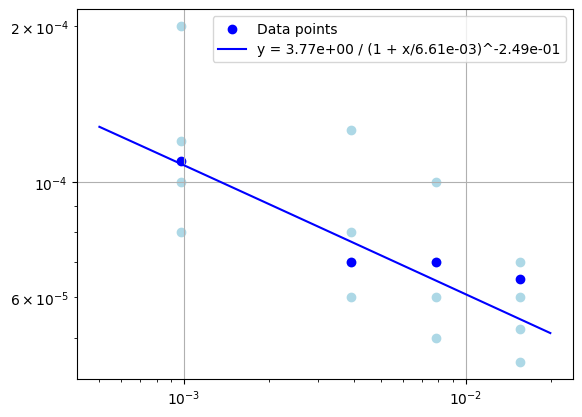

In [8]:
# Pushing, 2x width - fit


n_parallel = np.array([512, 1024, 2048, 8192])
utd = 1/n_parallel * 8
learning_rate = np.array([6e-5, 7e-5, 7e-5, 1e-4])
learning_rate = np.array([6.5e-5, 7e-5, 7e-5, 1.1e-4]) # uncertainty corrected
fit_data_points = [1, 2, 3]
plot_data_points = [0, 1, 2, 3]
lr_tried_values = [[6e-5, 7e-5], [5e-5, 1e-4], [6e-5, 1.26e-4], [1e-4, 2e-4]]
lr_tried_values = [[5.2e-5, 4.5e-5, 6e-5, 7e-5], [5e-5, 6e-5, 7e-5, 1e-4], [6e-5, 7e-5, 8e-5, 1.26e-4], [1.2e-4, 8e-5, 1e-4, 2e-4]] # values to try

scaling = [1000, 10000]
fitted_params = fit(utd[fit_data_points] * scaling[0], learning_rate[fit_data_points] * scaling[1], lr_rule_min,
                     [slice(-4, 4, 1.6),slice(1e-5, 5e-4, 1e-4),slice(-10, 10, 4)], maxiter=100)
print('loss', lr_rule_min(fitted_params, utd[fit_data_points] * scaling[0], learning_rate[fit_data_points] * scaling[1]))
a, b, c = fitted_params
x_smooth = np.logspace(-0.3, 1.3, 100)
y_fitted = lr_rule(x_smooth, a, b, c)

for i, lr_tried in enumerate(lr_tried_values):
    plt.scatter([utd[i]]*len(lr_tried), lr_tried, color='lightblue')
plt.scatter(utd[plot_data_points], learning_rate[plot_data_points], color='blue', label='Data points')
plt.plot(x_smooth / scaling[0], y_fitted / scaling[1], 'b-', label=f'y = {c:.2e} / (1 + x/{b:.2e})^-{a:.2e}')
print()
plt.xscale('log')
plt.yscale('log')
plt.grid(True)
plt.legend()
plt.show()

In [70]:
# Extrapolate

def get_lr(n_parallel):
    utd = 8/n_parallel * scaling[0]  # Scale UTD ratio same as training data
    predicted_lr = lr_rule(utd, a, b, c) / scaling[1]  # Unscale the prediction
    return predicted_lr

print(f'Predicted learning rate for n_parallel=256: {get_lr(256):.2e}')
print(f'Predicted learning rate for n_parallel=512: {get_lr(512):.2e}')
print(f'Predicted learning rate for n_parallel=1024: {get_lr(1024):.2e}')
print(f'Predicted learning rate for n_parallel=2048: {get_lr(2048):.2e}')
print(f'Predicted learning rate for n_parallel=4096: {get_lr(4096):.2e}')
print(f'Predicted learning rate for n_parallel=8192: {get_lr(8192):.2e}')


Predicted learning rate for n_parallel=256: 4.49e-05
Predicted learning rate for n_parallel=512: 5.24e-05
Predicted learning rate for n_parallel=1024: 6.12e-05
Predicted learning rate for n_parallel=2048: 7.14e-05
Predicted learning rate for n_parallel=4096: 8.33e-05
Predicted learning rate for n_parallel=8192: 9.73e-05


27.472123918445998
0.0021486636720810383 loss
y = -1.73e+00 + (x/2.73e+04)^-1.24e-01


/home/oleh/miniconda3/envs/rlgpu/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in power
  import sys
/home/oleh/miniconda3/envs/rlgpu/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in log
  """


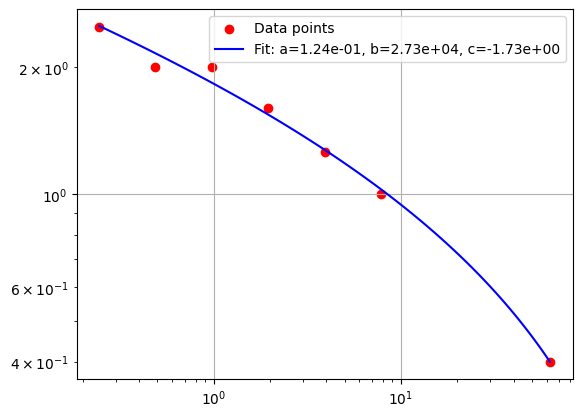

In [14]:
# learning rate - minimize()

n_parallel = np.array([128, 1024, 2048, 4096, 8192, 16384, 32768])/1000
utd = 1/n_parallel * 8
learning_rate = np.array([4e-5, 1e-4, 1.26e-4, 1.6e-4, 2e-4, 2e-4, 2.5e-4]) * 10000

optim_f = power_law_with_const_min
current_params = [-2.50000000e+00,  4.75000000e+00,  1e-04]
print(optim_f(current_params, utd, learning_rate))
lbfgs_pred = scipy.optimize.minimize(optim_f, current_params, args=((utd,), learning_rate), method='L-BFGS-B', tol=1e-10).x
# print(lbfgs_pred)
print(optim_f(lbfgs_pred, utd, learning_rate), 'loss')

# Plot the fit
x_smooth = np.logspace(np.log10(np.min(utd)), np.log10(np.max(utd)), 100)
y_fitted = power_law_with_const(x_smooth, *lbfgs_pred)

plt.figure()
plt.scatter(utd, learning_rate, color='red', label='Data points')
plt.plot(x_smooth, y_fitted, 'b-', label=f'Fit: a={lbfgs_pred[0]:.2e}, b={lbfgs_pred[1]:.2e}, c={lbfgs_pred[2]:.2e}')
print(f'y = {lbfgs_pred[2]:.2e} + (x/{lbfgs_pred[1]:.2e})^-{lbfgs_pred[0]:.2e}')
plt.xscale('log')
plt.yscale('log')
plt.grid(True)
plt.legend()
plt.show()



  6%|▋         | 8/125 [00:00<00:03, 36.07it/s]/home/oleh/miniconda3/envs/rlgpu/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in log
  """
 26%|██▋       | 33/125 [00:00<00:01, 47.86it/s]/home/oleh/miniconda3/envs/rlgpu/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in power
  import sys
100%|██████████| 125/125 [00:02<00:00, 52.97it/s]


0.002654084755498555 loss
y = -1.30e+00 + (x/2.80e+03)^-1.43e-01


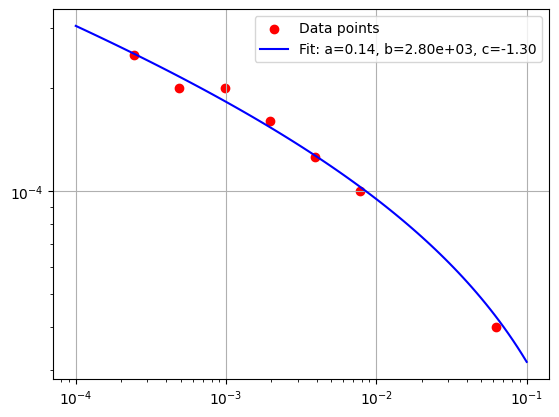

In [21]:
# learning rate - fit()

n_parallel = np.array([128, 1024, 2048, 4096, 8192, 16384, 32768])
utd = 1/n_parallel * 8
learning_rate = np.array([4e-5, 1e-4, 1.26e-4, 1.6e-4, 2e-4, 2e-4, 2.5e-4])
fit_data_points = [1, 2, 3, 4, 5, 6]

rescaling = [1000, 10000]
fitted_params = fit(utd[fit_data_points] * rescaling[0], learning_rate[fit_data_points] * rescaling[1], power_law_with_const_min,
                     [slice(-4, 4, 1.6),slice(1, 10, 2),slice(1e-5, 5e-4, 1e-4)], disp=False, maxiter=100)
print(power_law_with_const_min(fitted_params, utd[fit_data_points] * rescaling[0], learning_rate[fit_data_points] * rescaling[1]), 'loss')

x_smooth = np.logspace(-1, 2, 100)
a, b, c = fitted_params
y_fitted = power_law_with_const(x_smooth, a, b, c)

plt.scatter(utd, learning_rate, color='red', label='Data points')
plt.plot(x_smooth / rescaling[0], y_fitted / rescaling[1], 'b-', label=f'Fit: a={a:.2f}, b={b:.2e}, c={c:.2f}')
print(f'y = {c:.2e} + (x/{b:.2e})^-{a:.2e}')
plt.xscale('log')
plt.yscale('log')
plt.grid(True)
plt.legend()
plt.show()



/home/oleh/miniconda3/envs/rlgpu/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in log
  # Remove the CWD from sys.path while we load stuff.
/home/oleh/miniconda3/envs/rlgpu/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in log
  # Remove the CWD from sys.path while we load stuff.
/home/oleh/miniconda3/envs/rlgpu/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in log
  # Remove the CWD from sys.path while we load stuff.
/home/oleh/miniconda3/envs/rlgpu/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in log
  # Remove the CWD from sys.path while we load stuff.
/home/oleh/miniconda3/envs/rlgpu/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in log
  # Remove the CWD from sys.path while we load stuff.
/home/oleh/miniconda3/envs/rlgpu/lib/python3.7/sit

loss 0.41987349469597063
y = 2.00e+00 / (1 + x/1.09e-05)^-8.00e-01


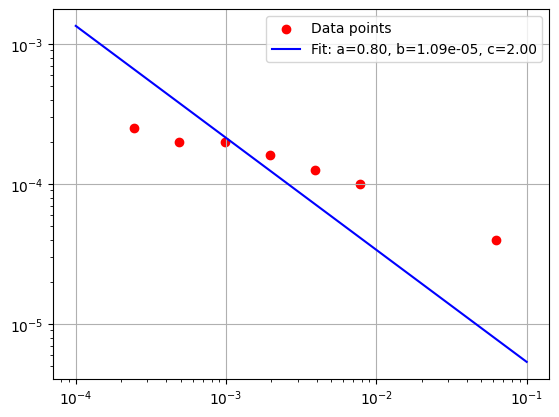

In [30]:
# large-batch training - log space - fit()

def lr_rule_min(args, *params):
    x,y = params
    a,b,c = args
    return ((log_lr_rule(x,a,b,c) - np.log(y)) ** 2).mean()
    # return ((np.log(lr_rule(x,a,b,c) / y)) ** 2).mean()

def log_lr_rule(x, a, b, c):
    return np.log(c) - a * np.log(1 + x/b)

n_parallel = np.array([128, 1024, 2048, 4096, 8192, 16384, 32768])
utd = 1/n_parallel * 8
learning_rate = np.array([4e-5, 1e-4, 1.26e-4, 1.6e-4, 2e-4, 2e-4, 2.5e-4])
fit_data_points = [1, 2, 3, 4, 5, 6]

scaling = [1000, 1]
fitted_params = fit(utd[fit_data_points] * scaling[0], learning_rate[fit_data_points] * scaling[1], lr_rule_min,
                     [slice(-4, 4, 1.6),slice(1e-5, 5e-4, 1e-4),slice(-10, 10, 4)], maxiter=100)
print('loss', lr_rule_min(fitted_params, utd[fit_data_points] * scaling[0], learning_rate[fit_data_points] * scaling[1]))
a, b, c = fitted_params
x_smooth = np.logspace(-1, 2, 100)
y_fitted = np.exp(log_lr_rule(x_smooth, a, b, c))

plt.scatter(utd, learning_rate, color='red', label='Data points')
plt.plot(x_smooth / scaling[0], y_fitted / scaling[1], 'b-', label=f'Fit: a={a:.2f}, b={b:.2e}, c={c:.2f}')
print(f'y = {c:.2e} / (1 + x/{b:.2e})^-{a:.2e}')
plt.xscale('log')
plt.yscale('log')
plt.grid(True)
plt.legend()
plt.show()

In [18]:
daily_prob = 1e-2
total_days = 8 * 365 / 3
total_prob = 1 - (1 - daily_prob) ** total_days
total_prob


0.9999435596876843